In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


EXPT = 'ASENSORY_AZ'
# EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

COLORS = {
    'G2': 'r', 'G3': 'c', 'G4': 'g', 'G5': 'm',
    'Motion': 'k', 'ForVel': 'k', 'AngVel': 'k', 'AbsAngVel': 'k', 'Heading': 'k', 'AbsHeading': 'k',
}

MVNG_ONLY = True
USE_CONV = False
T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

XMPL_TRIALS = {
    ('ASENSORY_AZ', False): '20160524.Fly1.1',
    ('ASENSORY_AZ', True): '20180413.Fly9.2',
    ('CL_360_LOWFLOW_ACV', False): '20170826.Fly4.1',
    ('CL_360_LOWFLOW_ACV', True): '20170828.Fly2.2',
    ('CL_180_HighFlow_ACV', False): '20170117.Fly1.2',
    ('CL_180_HighFlow_ACV', True): '20170111.Fly2.3',
}

TARGS = ['G2', 'G3', 'G4', 'G5']
if EXPT == 'ASENSORY_AZ':
    SRCS = ['Motion', 'ForVel', 'AngVel', 'AbsAngVel', 'Heading', 'AbsHeading']
else:
    SRCS = ['Motion', 'ForVel', 'AngVel', 'AbsAngVel', 'AbsHeading']
    
DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'DAN_FROM_BEHAV_FILTERS_WITH_CONV')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize/mask

In [2]:
if EXPT == 'ASENSORY_AZ':
    base = 'BigMAT.csv'
    mvng = 'Moving_Bouts.csv'
    mvng_cols = ['T1', 'T2']
else:
    base = 'clean.csv'
    mvng = 'moving.csv'
    mvng_cols = ['Start', 'Stop']
    
trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # select relevant columns
        if EXPT == 'ASENSORY_AZ':
            if not USE_CONV:
                data_u_ = data_u_[[
                    'Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion', 'ForVel', 'AngVel', 'Heading'
                ]]
            else:
                data_u_ = data_u_[[
                    'Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion_Conv', 'ForVel_Conv', 'AngVel_Conv', 'Heading'
                ]]
                data_u_ = data_u_.rename(
                    columns={'Motion_Conv': 'Motion', 'ForVel_Conv': 'ForVel', 'AngVel_Conv': 'AngVel'})

            data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
            data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        else:
            if not USE_CONV:
                data_u_ = data_u_[[
                    'Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion', 'ForVel', 'AngVel', 'AbsHeading',
                ]]
            else:
                data_u_ = data_u_[[
                    'Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion_Conv', 'ForVel_Conv', 'AngVel_Conv', 'AbsHeading',
                ]]
                data_u_ = data_u_.rename(
                    columns={'Motion_Conv': 'Motion', 'ForVel_Conv': 'ForVel', 'AngVel_Conv': 'AngVel'})
            data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
            
        data_u_ = data_u_.rename(
            columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # subsample data if MVNG_ONLY is True
        if MVNG_ONLY:
            t_mask = np.zeros(len(data_u_), dtype=bool)
            
            if not os.path.exists(os.path.join(trial_path, mvng)):
                continue
                
            df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
            
            for start, stop in zip(df_mvng[mvng_cols[0]], df_mvng[mvng_cols[1]]):
                t_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
                
            # TODO: create t_mask by opening moving bouts file
            data_u_[~t_mask] = np.nan
        
        data_u[trial] = data_u_
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_ -= data_n_.mean()
        data_n_ /= data_n_.std()
        
        # replace normalized time column with original time column
        data_n_['Time'] = data_u_['Time']
        
        data_n[trial] = data_n_
        
        trials.append(trial)

In [3]:
data_u_.columns

Index(['Time', 'G2', 'G3', 'G4', 'G5', 'Motion', 'ForVel', 'AngVel', 'Heading',
       'AbsAngVel', 'AbsHeading'],
      dtype='object')

# Fit trial-by-trial filters

In [4]:
# create initial filter dataframes
t_h = np.arange(*T_WDW, DT)
df_blank = pd.DataFrame(
    np.nan,
    index=sorted(list(data_n)),
    columns=(['N', 'R2', 'R2_ADJ'] + list(t_h[TRUNCATE:-TRUNCATE]))).rename_axis('TRIAL')

filters = {'{}_FROM_{}'.format(targ, src.upper()): df_blank.copy() for targ, src in list(c_product(TARGS, SRCS))}

xmpl_idx = ['TIME'] + [src.upper() for src in SRCS] + \
    [targ.upper() for targ in TARGS] + \
    ['{}_FROM_{}'.format(targ, src.upper()) for targ, src in c_product(TARGS, SRCS)]

wdws_d = [None, None]
wdws_d[0] = int(round(T_WDW[0]/DT))
wdws_d[1] = wdws_d[0] + int(len(t_h))

df_xmpl = None

r2_adj_all = {(src, targ): [] for src, targ in c_product(SRCS, TARGS)}

# loop over trials
for trial in trials:
    data_n_ = data_n[trial]
    if trial == XMPL_TRIALS[(EXPT, MVNG_ONLY)]:
        df_xmpl = pd.DataFrame(np.nan, index=xmpl_idx, columns=np.array(data_n_['Time'])).rename_axis('VAR')
        for v in ['Time'] + SRCS + TARGS:
            df_xmpl.loc[v.upper()] = np.array(data_n_[v])
        
    # loop over srcs
    for src in SRCS:
        # loop over targs
        for targ in TARGS:
            # compute filter
            xs = {src: np.array(data_n_[src])}
            y = np.array(data_n_[targ])
            
            if not USE_CONV:
#                 params = {'model': linear_model.LinearRegression}
                params = {'model': linear_model.Ridge, 'alpha': 100}
            else:
                params = {'model': linear_model.Ridge, 'alpha': 100}
                
            hs, icpt, y_hat, r2 = fit_h(
                xs, y, {src: wdws_d}, [src], 'built-in', params=params)
            
            n = np.sum(~np.isnan(y_hat))
            
            # compute adjusted R2 values
            mask = (~np.isnan(y)) & (~np.isnan(y_hat))

            r2_adj = np.nan

            if mask.sum() > 3:
                r, p = stats.pearsonr(y[mask], y_hat[mask])
                #if src == 'ForVel' and targ == 'G4':
                    #print('R2(y, y_hat) = {0:.3f}, P = {1:.3f}, N = {4}'.format(r**2, p, src, targ, mask.sum()))
                n_adj = mask.sum()/4  # approximately adjust for correlation time of DAN signal
                n_p = len(hs[src])

                if n_adj - n_p - 1 > 0:
                    r2_adj = 1 - (1 - r**2)*(n_adj - 1)/(n_adj - n_p - 1)
                    #if src == 'ForVel' and targ == 'G4':
                        #print('R2_ADJ(y, y_hat) = {0:.3f}, P = {1:.3f}, N = {4}'.format(r2_adj, p, src, targ, mask.sum()))
                
            # store filter
            filters['{}_FROM_{}'.format(targ, src.upper())].loc[trial] = [n, r2, r2_adj] + list(hs[src][TRUNCATE:-TRUNCATE])
            
            # store data if xmpl trial
            if trial == XMPL_TRIALS[(EXPT, MVNG_ONLY)]:
                df_xmpl.loc['{}_FROM_{}'.format(targ, src.upper())] = y_hat
                
            # store adjusted R2
            r2_adj_all[(src, targ)].append(r2_adj)

# save all filters
if not USE_CONV:
    for k, df_save in filters.items():
        if MVNG_ONLY:
            sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY.csv'.format(EXPT, k, *T_WDW_TR)
        else:
            sfx = '{}_{}_T_WDW_{}_{}.csv'.format(EXPT, k, *T_WDW_TR)

        df_save.to_csv(os.path.join(SAVE_DIR, sfx), na_rep='NaN')

    # save example trial
    if df_xmpl is not None:
        if MVNG_ONLY:
            sfx = '{}_XMPL_{}_T_WDW_{}_{}_MVNG_ONLY.csv'.format(EXPT, XMPL_TRIALS[(EXPT, MVNG_ONLY)], *T_WDW_TR)
        else:
            sfx = '{}_XMPL_{}_T_WDW_{}_{}.csv'.format(EXPT, XMPL_TRIALS[(EXPT, MVNG_ONLY)], *T_WDW_TR)

        df_xmpl.T.to_csv(os.path.join(SAVE_DIR, sfx), na_rep='NaN')
    else:
        raise Exception('Example trial not in trial set.')
        
else:
    for k, df_save in filters.items():
        if MVNG_ONLY:
            sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY_CONV.csv'.format(EXPT, k, *T_WDW_TR)
        else:
            sfx = '{}_{}_T_WDW_{}_{}_CONV.csv'.format(EXPT, k, *T_WDW_TR)

        df_save.to_csv(os.path.join(SAVE_DIR, sfx), na_rep='NaN')

    # save example trial
    if df_xmpl is not None:
        if MVNG_ONLY:
            sfx = '{}_XMPL_{}_T_WDW_{}_{}_MVNG_ONLY_CONV.csv'.format(EXPT, XMPL_TRIALS[(EXPT, MVNG_ONLY)], *T_WDW_TR)
        else:
            sfx = '{}_XMPL_{}_T_WDW_{}_{}_CONV.csv'.format(EXPT, XMPL_TRIALS[(EXPT, MVNG_ONLY)], *T_WDW_TR)

        df_xmpl.T.to_csv(os.path.join(SAVE_DIR, sfx), na_rep='NaN')
    else:
        raise Exception('Example trial not in trial set.')

In [5]:
sorted(trials)

['20151230.Fly1.1',
 '20151230.Fly1.2',
 '20151230.Fly1.3',
 '20160118.Fly1.2',
 '20160118.Fly1.3',
 '20160118.Fly1.4',
 '20160118.Fly1.6',
 '20160118.Fly1.7',
 '20160118.Fly1.8',
 '20160118.Fly2.1',
 '20160118.Fly2.2',
 '20160118.Fly2.3',
 '20160118.Fly2.4',
 '20160118.Fly2.5',
 '20160118.Fly2.6',
 '20160118.Fly4.1',
 '20160118.Fly4.2',
 '20160118.Fly4.3',
 '20160118.Fly4.4',
 '20160118.Fly4.5',
 '20160118.Fly4.6',
 '20160118.Fly4.7',
 '20160118.Fly4.8',
 '20160119.Fly1.1',
 '20160119.Fly1.2',
 '20160119.Fly1.3',
 '20160119.Fly1.4',
 '20160119.Fly3.1',
 '20160119.Fly3.2',
 '20160119.Fly3.3',
 '20160119.Fly3.4',
 '20160119.Fly3.5',
 '20160130.Fly3.1',
 '20160130.Fly3.2',
 '20160130.Fly3.3',
 '20160130.Fly3.4',
 '20160130.Fly3.5',
 '20160130.Fly3.6',
 '20160130.Fly3.7',
 '20160201.Fly2.1',
 '20160201.Fly2.3',
 '20160201.Fly2.4',
 '20160201.Fly2.5',
 '20160201.Fly2.6',
 '20160201.Fly2.7',
 '20160202.Fly1.1',
 '20160202.Fly1.2',
 '20160202.Fly1.3',
 '20160202.Fly1.4',
 '20160203.Fly4.1',


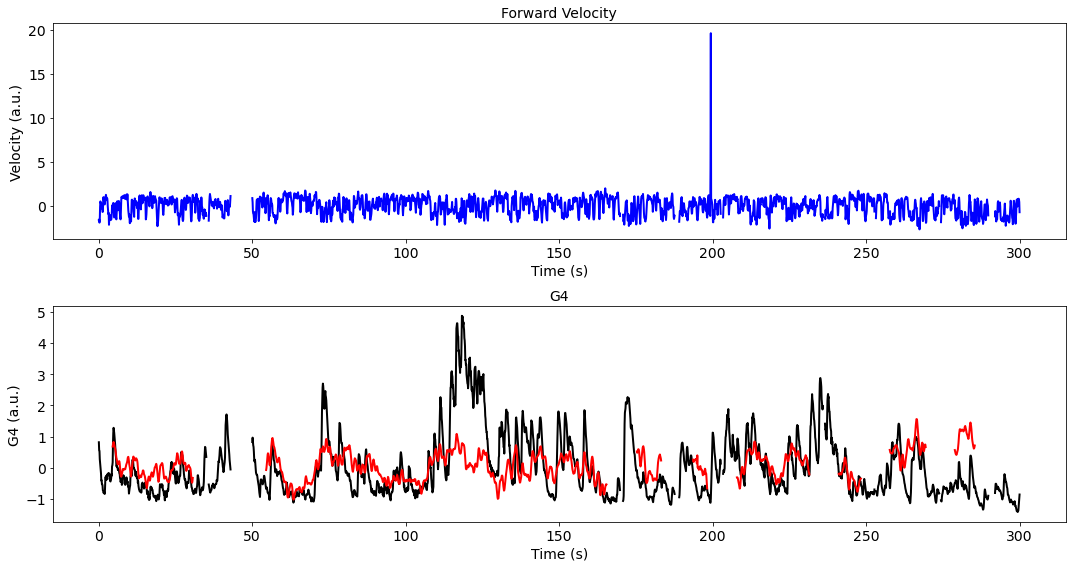

In [6]:
# plot example
fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)

df = pd.read_csv(os.path.join(SAVE_DIR, sfx), index_col=0)
axs[0].plot(df['TIME'], df['FORVEL'], color='b', lw=2)
axs[0].set_title('Forward Velocity')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Velocity (a.u.)')

axs[1].plot(df['TIME'], df['G4'], color='k', lw=2)
axs[1].plot(df['TIME'], df['G4_FROM_FORVEL'], color='r', lw=2)
axs[1].set_title('G4')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('G4 (a.u.)')

for ax in axs:
    set_font_size(ax, 14)

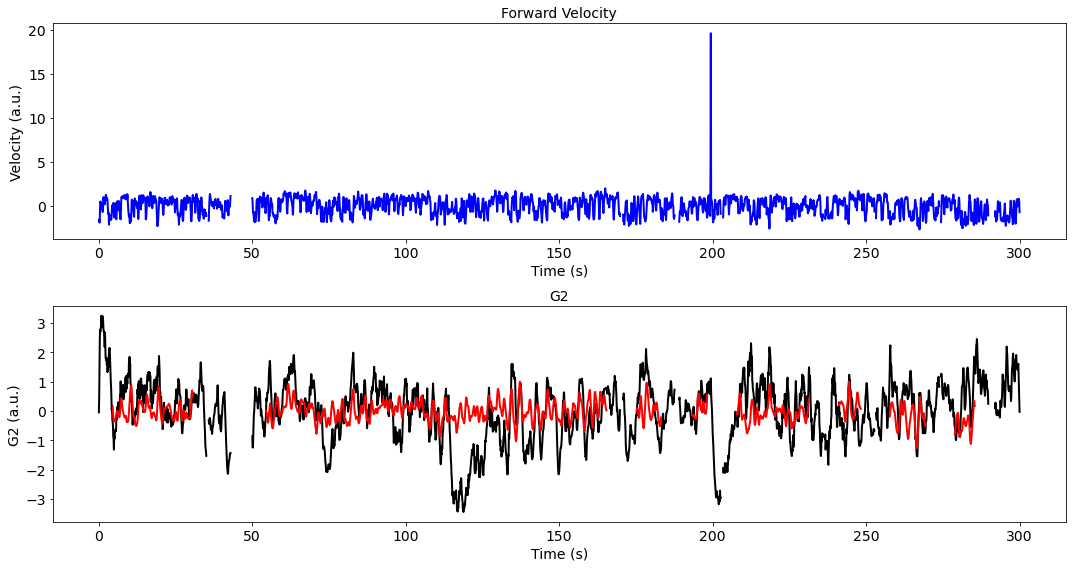

In [7]:
# plot example
fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)

df = pd.read_csv(os.path.join(SAVE_DIR, sfx), index_col=0)
axs[0].plot(df['TIME'], df['FORVEL'], color='b', lw=2)
axs[0].set_title('Forward Velocity')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Velocity (a.u.)')

axs[1].plot(df['TIME'], df['G2'], color='k', lw=2)
axs[1].plot(df['TIME'], df['G2_FROM_FORVEL'], color='r', lw=2)
axs[1].set_title('G2')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('G2 (a.u.)')

for ax in axs:
    set_font_size(ax, 14)

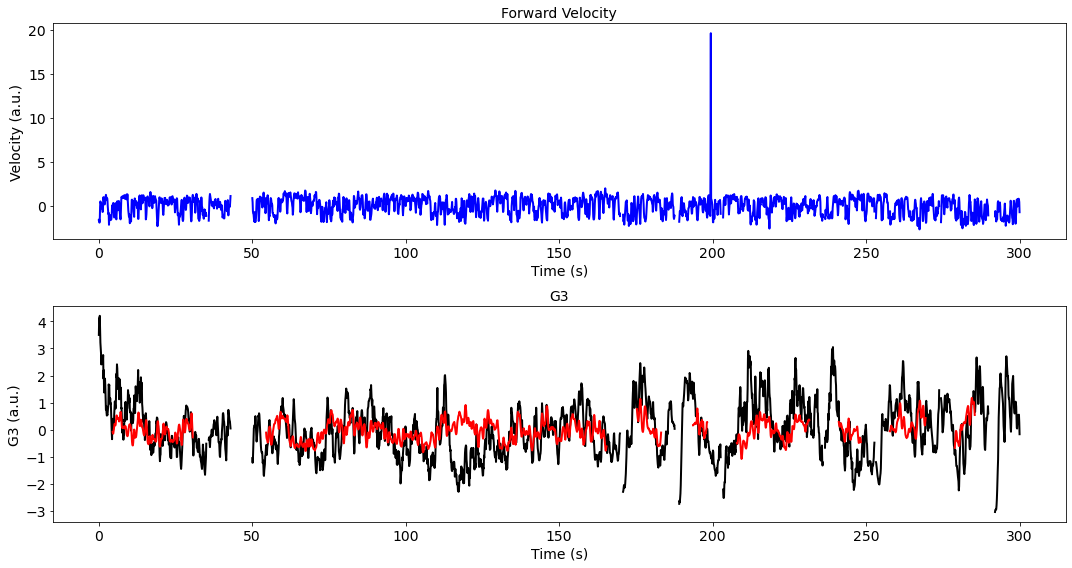

In [8]:
# plot example
fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)

df = pd.read_csv(os.path.join(SAVE_DIR, sfx), index_col=0)
axs[0].plot(df['TIME'], df['FORVEL'], color='b', lw=2)
axs[0].set_title('Forward Velocity')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Velocity (a.u.)')

axs[1].plot(df['TIME'], df['G3'], color='k', lw=2)
axs[1].plot(df['TIME'], df['G3_FROM_FORVEL'], color='r', lw=2)
axs[1].set_title('G3')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('G3 (a.u.)')

for ax in axs:
    set_font_size(ax, 14)

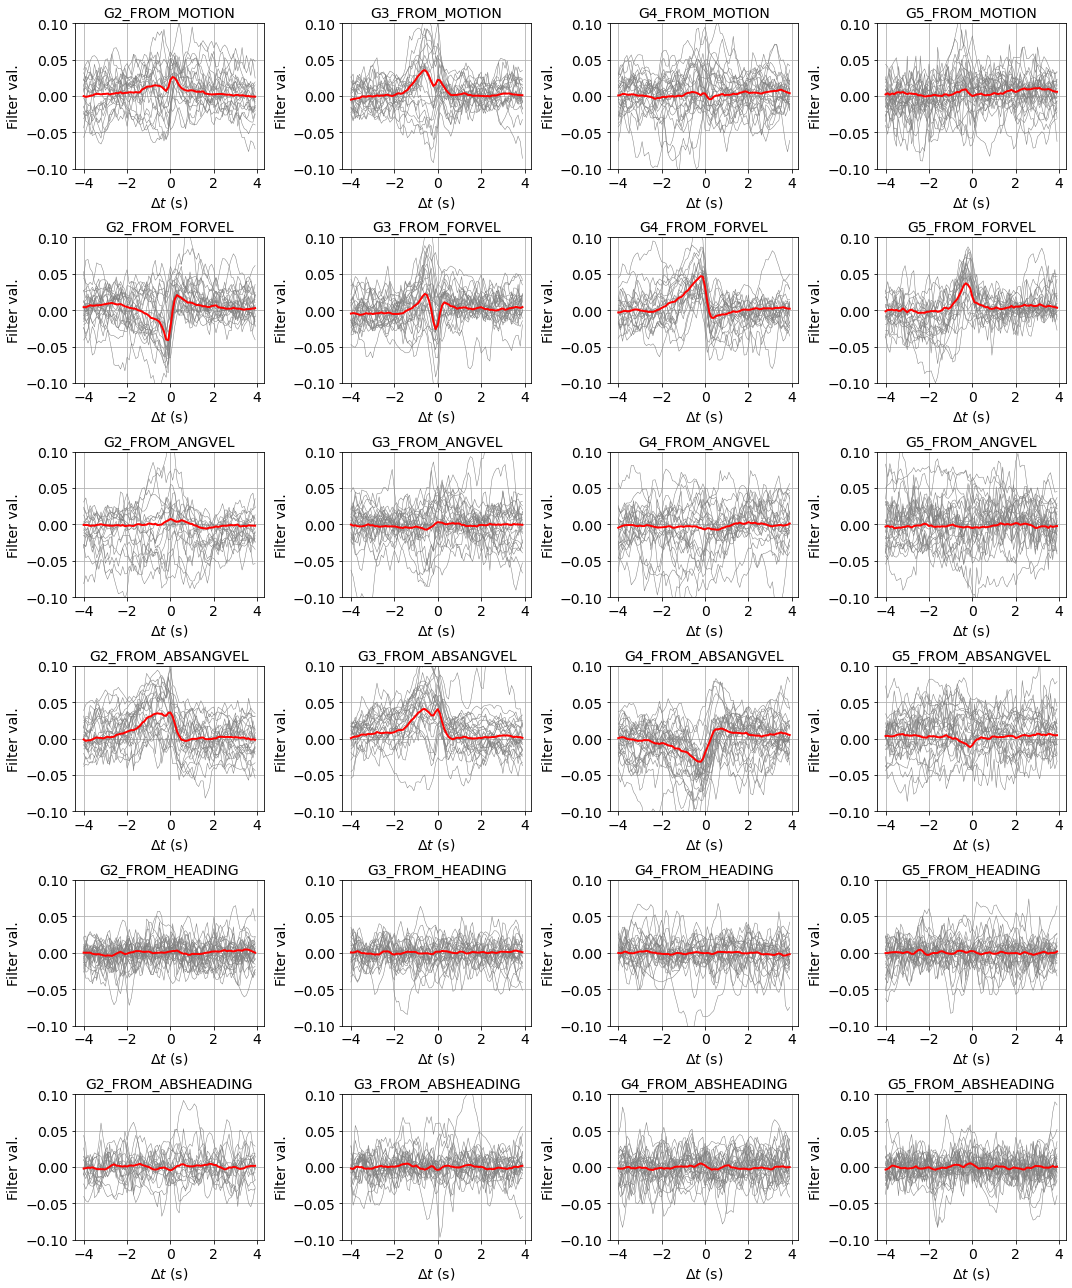

In [9]:
# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        if not USE_CONV:
            if MVNG_ONLY:
                sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY.csv'.format(EXPT, k, *T_WDW_TR)
            else:
                sfx = '{}_{}_T_WDW_{}_{}.csv'.format(EXPT, k, *T_WDW_TR)
        else:
            if MVNG_ONLY:
                sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY_CONV.csv'.format(EXPT, k, *T_WDW_TR)
            else:
                sfx = '{}_{}_T_WDW_{}_{}_CONV.csv'.format(EXPT, k, *T_WDW_TR)
        df = pd.read_csv(os.path.join(SAVE_DIR, sfx), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T[3:], lw=.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.mean())[3:], lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('$\Delta t$ (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)

Plot adjusted R2 values

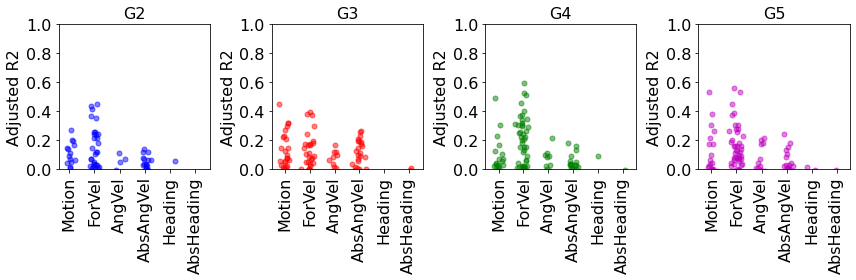

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), tight_layout=True)
cs = ['b', 'r', 'g', 'm']

for targ, c, ax in zip(TARGS, cs, axs):
    for s_ctr, src in enumerate(SRCS):
        r2_adj = r2_adj_all[(src, targ)]
        xs = s_ctr + .1*np.random.randn(len(r2_adj))
        ax.scatter(xs, r2_adj, c=c, s=25, alpha=.5)
    
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(SRCS)))
    ax.set_xticklabels(SRCS, rotation=90)
    ax.set_ylabel('Adjusted R2')
    ax.set_title(targ)
    
for ax in axs:
    set_font_size(ax, 16)

In [11]:
columns = ['BEHAV', 'DAN'] + trials
df_r2_adj = pd.DataFrame(columns=columns)

In [12]:
for ctr, ((behav, dan), r2) in enumerate(r2_adj_all.items()):
    df_r2_adj.loc[ctr] = [behav, dan] + list(r2)

In [13]:
if not USE_CONV:
    df_r2_adj.to_csv(os.path.join(SAVE_DIR, f'R2_ADJ_{EXPT}.csv'), na_rep='NaN', index=False)
else:
    df_r2_adj.to_csv(os.path.join(SAVE_DIR, f'R2_ADJ_{EXPT}_CONV.csv'), na_rep='NaN', index=False)

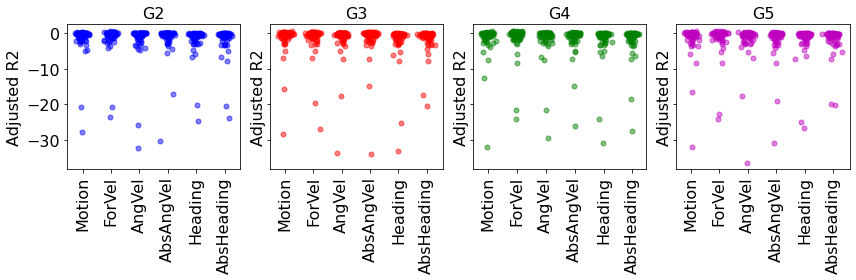

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), tight_layout=True, sharey=True)
cs = ['b', 'r', 'g', 'm']

for targ, c, ax in zip(TARGS, cs, axs):
    for s_ctr, src in enumerate(SRCS):
        r2_adj = r2_adj_all[(src, targ)]
        xs = s_ctr + .1*np.random.randn(len(r2_adj))
        ax.scatter(xs, r2_adj, c=c, s=25, alpha=.5)
    
    ax.set_xticks(range(len(SRCS)))
    ax.set_xticklabels(SRCS, rotation=90)
    ax.set_ylabel('Adjusted R2')
    ax.set_title(targ)
    
for ax in axs:
    set_font_size(ax, 16)